# Comparison between multiple text to image models

In [1]:
import diffusers
from diffusers import DiffusionPipeline, EulerDiscreteScheduler
import torch


# Configuration
torch_precision = torch.float16
diffusers.utils.logging.disable_progress_bar

# Models to test
## Note: Stable Diffusion 3 should be tested apart, or you might get an "out of memory" error
models_info = [
    {
        "name": "Stable Diffusion 3 Medium Diffusers",
        "model_name": "stabilityai/stable-diffusion-3-medium-diffusers",
        "inference_config": {
            "num_inference_steps":50,
            "guidance_scale":7.0,
        }
    },
    {
        "name": "Stable Diffusion XL Base", 
        "model_name": "stabilityai/stable-diffusion-xl-base-1.0",
        "inference_config": {
            "num_inference_steps": 40,
        }
    },
    {
        "name": "Stable Diffusion XL Turbo",
        "model_name": "stabilityai/sdxl-turbo",
        "inference_config": {
            "num_inference_steps": 5, 
            "guidance_scale": 0.0
        }
    },

    # Models with custom weights
    {
        "name": "3D Render Style SDXL",
        "model_name": "stabilityai/stable-diffusion-xl-base-1.0",
        "weights": "goofyai/3d_render_style_xl",
        "trigger": "3D Render, "
    },
    {
        "name": "3D Redmond SDXL",
        "model_name": "stabilityai/stable-diffusion-xl-base-1.0",
        "weights": "artificialguybr/3DRedmond-V1",
        "trigger": "3D Render Style, 3DRenderAF, "
    },
    
    # The results are too bad :P
    # {
    #     "name": "Stable Diffusion 2.1 Base", 
    #     "model_name": "stabilityai/stable-diffusion-2-1-base",
    #     "inference_config": { }
    # },
]

prompt_templates = [
    "Professional 3d model of a {subject} dramatic lighting, highly detailed, volumetric, cartoon",
    "A statue of a white minimalist low polygon 3d printed {subject} on a pedestal. With black background",
]
prompt_subjects = [
    "cute anime girl in a shrine maiden outfit with fox ears hugging her big fluffy tail",
    "Wolpertinger",
    "panda with a straw hat and sunglasses sitting on a beach chair and drinking a cocktail",
    "elephant with a hat",
    "old steam locomotive",
    "old man wearing a beret",
    "cat with a hat, next to a dog with a funny mustache, and in fron a very round chicken playing with a gameboy",
]

def load_model(model_info, torch_dtype):
    access_token = "Put your HF token here"

    torch.cuda.empty_cache()
    model = DiffusionPipeline.from_pretrained(model_info["model_name"], 
                                              torch_dtype=torch_dtype,
                                              token=access_token)
    if "weights" in model_info:
        model.load_lora_weights(model_info["weights"])

    model = model.to("cuda:0")
    model.set_progress_bar_config(disable=True)

    return model

import matplotlib.pyplot as plt
import numpy as np
def image_grid(imgs, rows, cols, title=None):
    assert len(imgs) == rows*cols

    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = axs.ravel()

    for i, img in enumerate(imgs):
        axs[i].imshow(np.array(img))
        axs[i].axis('off')

    if title:
        plt.suptitle(title, fontsize=12)

    plt.subplots_adjust(wspace=0, hspace=0.1)  # Adjust the space between images
    plt.show()

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


## Experiment
Test various text2image models with the same text to compare the results.

  0%|          | 0/1 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Processing prompts of template:   0%|          | 0/7 [00:00<?, ?it/s]

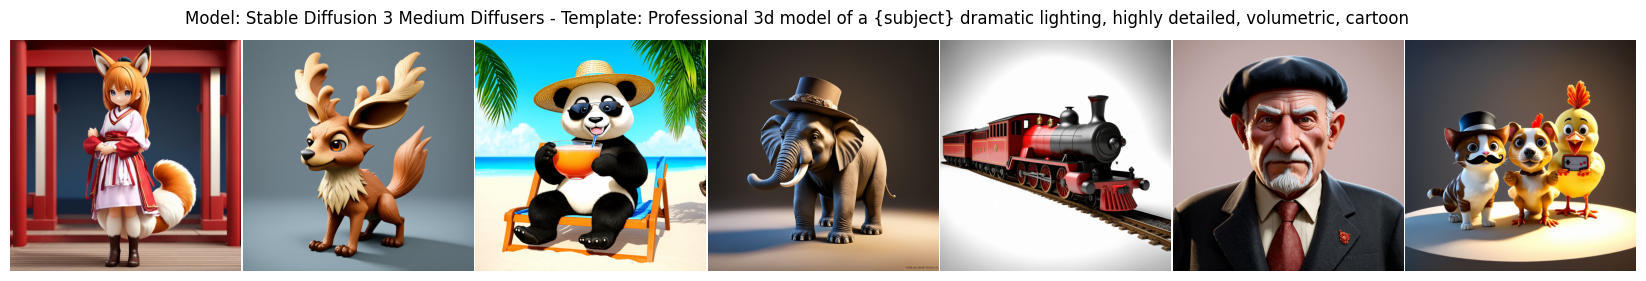

None

Processing prompts of template:   0%|          | 0/7 [00:00<?, ?it/s]

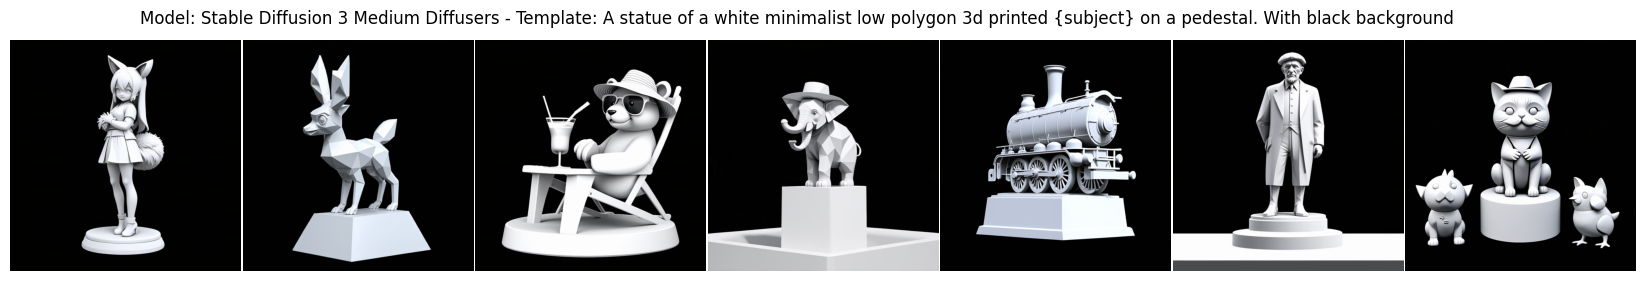

None

Time taken for Stable Diffusion 3 Medium Diffusers: 16.308110203061783 seconds per image
Time taken for Stable Diffusion 3 Medium Diffusers: 16.308110203061783 seconds per image


In [2]:
import time
from tqdm.notebook import tqdm

times = []

# Iterate over each model
for model_info in tqdm(models_info):
    # Load the model
    model = load_model(model_info, torch_precision)

    # Start timing
    start_time = time.time()

    # Iterate over each prompt template and subject
    for prompt_template in prompt_templates:
        images=[]
        for prompt_subject in tqdm(prompt_subjects, desc="Processing prompts of template"):

            # Format the prompt
            prompt = prompt_template.format(subject=prompt_subject)
            prompt = model_info.get("trigger", "") + prompt

            # Generate the image
            result = model(
                prompt=prompt, 
                num_images_per_prompt=1, 
              **model_info.get("inference_config", {})
            )
            
            # Save the image
            result.images[0].save(f"results/{model_info['name']}_{prompt}.png")
            images.append(result.images[0])
        
        # Display the images for the current prompt template
        grid = image_grid(images, rows=1, cols=len(images), title=f"Model: {model_info['name']} - Template: {prompt_template}")
        display(grid)

    # Calculate and print the time taken
    end_time = time.time()
    seconds_per_image = f"Time taken for {model_info['name']}: {(end_time - start_time) / (len(prompt_templates) * len(prompt_subjects))} seconds per image"
    times.append(seconds_per_image)
    print(seconds_per_image)

# Print the times taken for each model
for time_taken in times:
    print(time_taken)

## Test Stable Diffusion Cascade
Testing it appart because it doesn't work as easily with the DiffusionPipeline

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Processing prompts of template:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

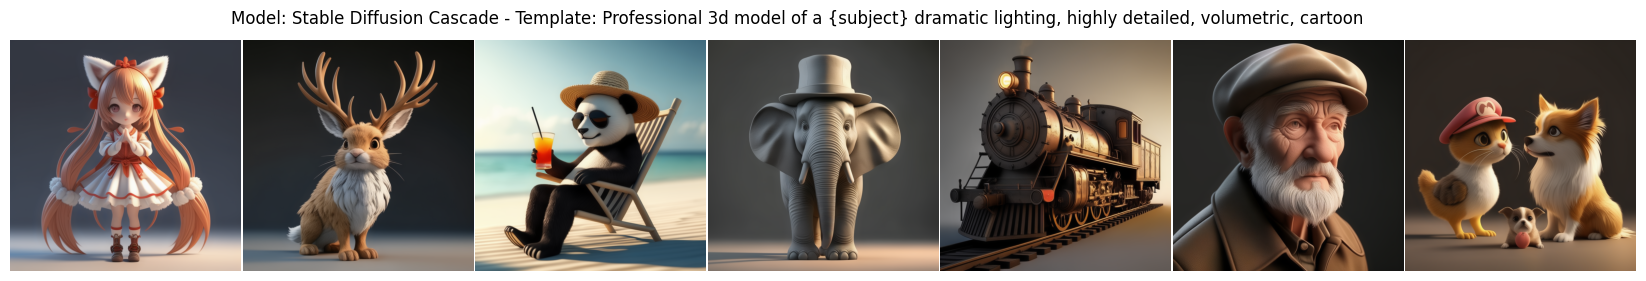

None

Processing prompts of template:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

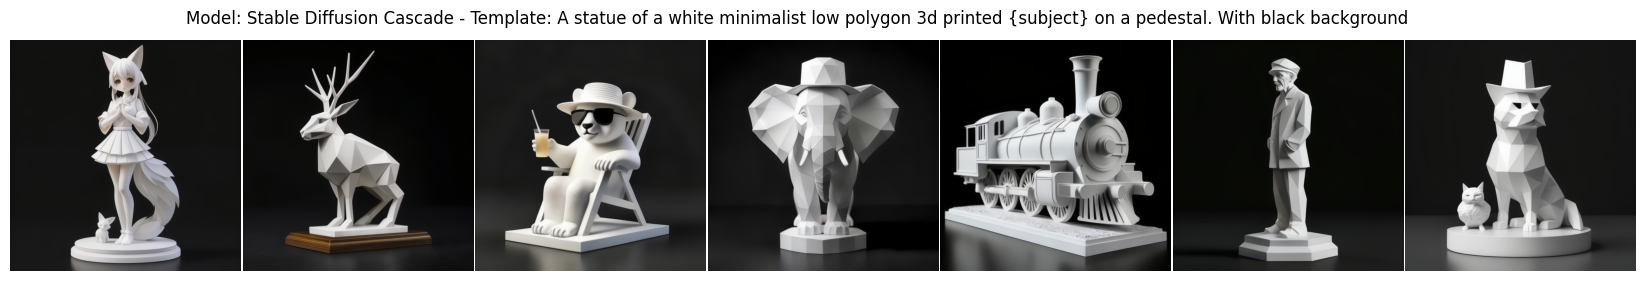

None

Time taken for Stable Diffusion Cascade: 13.75167829649789 seconds per image
Time taken for Stable Diffusion Cascade: 13.75167829649789 seconds per image


In [6]:
import time
from tqdm.notebook import tqdm
from diffusers import StableCascadeDecoderPipeline, StableCascadePriorPipeline

# Load the model
prior = StableCascadePriorPipeline.from_pretrained("stabilityai/stable-cascade-prior", variant="bf16", torch_dtype=torch.bfloat16)
decoder = StableCascadeDecoderPipeline.from_pretrained("stabilityai/stable-cascade", variant="bf16", torch_dtype=torch.float16)
prior.enable_model_cpu_offload()
decoder.enable_model_cpu_offload()

# Start timing
start_time = time.time()

# Iterate over each prompt template and subject
for prompt_template in prompt_templates:
    images=[]
    for prompt_subject in tqdm(prompt_subjects, desc="Processing prompts of template"):

        # Format the prompt
        prompt = prompt_template.format(subject=prompt_subject)

        # Generate the image
        prior_output = prior(
            prompt=prompt,
            height=1024,
            width=1024,
            guidance_scale=4.0,
            num_images_per_prompt=1,
            num_inference_steps=20
        )
        result = decoder_output = decoder(
            image_embeddings=prior_output.image_embeddings.to(torch.float16),
            prompt=prompt,
            guidance_scale=0.0,
            output_type="pil",
            num_inference_steps=10
        )
        
        # Save the image
        result.images[0].save(f"results/Stable Diffusion Cascade_{prompt}.png")
        images.append(result.images[0])
    
    # Display the images for the current prompt template
    grid = image_grid(images, rows=1, cols=len(images), title=f"Model: Stable Diffusion Cascade - Template: {prompt_template}")
    display(grid)

# Calculate and print the time taken
end_time = time.time()
print(f"Time taken for Stable Diffusion Cascade: {(end_time - start_time) / (len(prompt_templates) * len(prompt_subjects))} seconds per image")